# 1. Import

In [1]:
# ! pip install ucimlrepo

In [2]:
# reading data file
import pandas as pd
# numeric operations
import numpy as np
# plotting charts
from matplotlib import pyplot as plt
# inheritance
from abc import ABC
# custom enums
from enum import Flag, auto
# math.ceil() and measuring program's evaluation time
import math, time, copy
# reading remote dataset
from ucimlrepo import fetch_ucirepo

# 2. Additional implementations

In [3]:
eps = 1e-10
sec_per_op = 7 / 241250

In [4]:
def d(start, end):
    diff = math.ceil(end - start)
    
    hours = diff // 3600
    minutes = (diff - hours * 3600) // 60
    seconds = diff - hours * 3600 - minutes * 60
    
    return f'{hours}h {minutes}m {seconds}s', hours, minutes, seconds

In [5]:
def encode_one_hot(categories):
    unique_categories = np.unique(categories)
    one_hot_encoding = np.zeros((len(categories), len(unique_categories)), dtype=int)

    for i, category in enumerate(categories):
        index = np.where(unique_categories == category)[0][0]
        one_hot_encoding[i, index] = 1

    return(one_hot_encoding)

## 2.1. Cost

In [6]:
class ICost(ABC):
    @staticmethod
    def get(p_y_true, p_y_pred):
        pass
    
    @staticmethod
    def der(p_y_true, p_y_pred):
        pass
    
    @staticmethod
    def type():
        pass

In [7]:
class Cost:
    class Type(Flag):
        MSE = auto()
        CROSS_ENTROPY = auto()
        
    @staticmethod
    def from_type(p_type):
        assert type(p_type) == Cost.Type
        
        match p_type:
            case Cost.Type.MSE:
                return Cost.MSE()
            case Cost.Type.CROSS_ENTROPY:
                return Cost.CrossEntropy()
            case _:
                print("WARNING: Unknown cost function type. Using MSE instead.")
                return Cost.MSE()
    
    class MSE(ICost):
        @staticmethod
        def get(p_y_true, p_y_pred):
            errors = np.square(p_y_pred - p_y_true)
            
            return errors.mean()

        @staticmethod
        def der(p_y_true, p_y_pred):            
            return 2 * (p_y_pred - p_y_true)

        @staticmethod
        def type():
            return Cost.Type.MSE
    
    class CrossEntropy(ICost):
        @staticmethod
        def get(p_y_true, p_y_pred):
            errors = np.sum(-p_y_true * np.log(p_y_pred), axis=1)
            
            return errors.mean()

        @staticmethod
        def der(p_y_true, p_y_pred):
            return -p_y_true / p_y_pred

        @staticmethod
        def type():
            return Cost.Type.CROSS_ENTROPY

## 2.2. Metrics

In [8]:
class IMetric(ABC):
    @staticmethod
    def get(p_y_true, p_y_pred):
        pass
    
    @staticmethod
    def type():
        pass

In [9]:
class Metric:
    class Type(Flag):
        MSE = auto()
        F_SCORE = auto()
    
    @staticmethod
    def from_type(p_type):
        assert type(p_type) == Metric.Type
        
        match p_type:
            case Metric.Type.MSE:
                return Metric.MSE()
            case Metric.Type.F_SCORE:
                return Metric.F_score()
            case _:
                print("WARNING: Unkown metric function type. Using MSE instead.")
                return Metric.MSE()
    
    class MSE(IMetric):
        @staticmethod
        def get(p_y_true, p_y_pred):
            errors = np.square(p_y_pred - p_y_true)
            
            return errors.mean()

        @staticmethod
        def type():
            return Metric.Type.MSE
    
    class F_score(IMetric):
        @staticmethod
        def get(p_y_true, p_y_pred):
            true_positives = np.sum(np.logical_and(p_y_true == p_y_pred, p_y_pred == 1), axis=0)
            true_negatives = np.sum(np.logical_and(p_y_true == p_y_pred, p_y_pred == 0), axis=0)
            false_positives = np.sum(np.logical_and(p_y_true != p_y_pred, p_y_pred == 1), axis=0)
            false_negatives = np.sum(np.logical_and(p_y_true != p_y_pred, p_y_pred == 0), axis=0)

            return 2 * true_positives / (2 * true_positives + false_positives + false_negatives)

        @staticmethod
        def type():
            return Metric.Type.F_SCORE

## 2.3. Activation

In [10]:
class IActivation(ABC):
    @staticmethod
    def get(p_x):
        pass
    
    @staticmethod
    def der(p_x):
        pass
    
    @staticmethod
    def type():
        pass

In [11]:
class Activation:
    class Type(Flag):
        LINEAR = auto()
        SIGMOID = auto()
        TANH = auto()
        RE_LU = auto()
        LEAKY_RE_LU = auto()
        SOFTMAX = auto()
        
    @staticmethod
    def from_type(p_type):
        assert type(p_type) == Activation.Type
        
        match p_type:
            case Activation.Type.LINEAR:
                return Activation.Linear()
            case Activation.Type.SIGMOID:
                return Activation.Sigmoid()
            case Activation.Type.TANH:
                return Activation.Tanh()
            case Activation.Type.RE_LU:
                return Activation.ReLU()
            case Activation.Type.LEAKY_RE_LU:
                return Activation.LeakyReLU()
            case Activation.Type.SOFTMAX:
                return Activation.Softmax()
            case _:
                print("WARNING: Unknown activation function type. Using Tanh insted.")
                return Activation.Tanh()
                
    class Linear(IActivation):
        @staticmethod
        def get(p_x):
            return p_x

        @staticmethod
        def der(p_x):
            return np.ones(shape=p_x.shape)

        @staticmethod
        def type():
            return Activation.Type.LINEAR
    
    class Sigmoid(IActivation):
        @staticmethod
        def get(p_x):
            return 1 / (1 + np.exp(-p_x))

        @staticmethod
        def der(p_x):
            a = Activation.Sigmoid.get(p_x)
            
            return a * (1 - a)

        @staticmethod
        def type():
            return Activation.Type.SIGMOID
    
    class Tanh(IActivation):
        @staticmethod
        def get(p_x):
            return np.tanh(p_x)

        @staticmethod
        def der(p_x):
            a = Activation.Tanh.get(p_x)
            
            return 1 - a ** 2

        @staticmethod
        def type():
            return Activation.Type.TANH
    
    class ReLU(IActivation):
        @staticmethod
        def get(p_x):
            return np.where(p_x > 0, p_x, 0)

        @staticmethod
        def der(p_x):
            return np.where(p_x > 0, 1, 0)

        @staticmethod
        def type():
            return Activation.Type.RE_LU
    
    class LeakyReLU(IActivation):
        @staticmethod
        def get(p_x):
            return np.where(p_x > 0, p_x, 0.01 * p_x)

        @staticmethod
        def der(p_x):
            return np.where(p_x > 0, 1, 0.01)

        @staticmethod
        def type():
            return Activation.Type.LEAKY_RE_LU
    
    class Softmax(IActivation):
        @staticmethod
        def get(p_x):
            n = np.exp(p_x)
            d = np.sum(n, axis=1, keepdims=True)
            
            return n / d

        @staticmethod
        def der(p_x):
            raise Exception("ERROR: Activation.Softmax.der() is unusable.")

        @staticmethod
        def type():
            return Activation.Type.SOFTMAX

## 2.4. Weights initialization

In [12]:
class IWeights(ABC):
    @staticmethod
    def get(p_shape):
        pass
    
    @staticmethod
    def type():
        pass

In [13]:
class Weights:
    class Type(Flag):
        XAVIER = auto()
        HE = auto()
        UNIFORM = auto()
    
    @staticmethod
    def from_type(p_type):
        assert type(p_type) == Weights.Type
        
        match p_type:
            case Weights.Type.XAVIER:
                return Weights.Xavier()
            case Weights.Type.HE:
                return Weights.He()
            case Weights.Type.UNIFORM:
                return Weights.uniform()
            case _:
                print("WARNING: Unknown weights initialisation type. Using He insted.")
                return Weights.He()
    
    class Xavier(IWeights):
        @staticmethod
        def get(p_shape):
            n = p_shape[0] + p_shape[1]
            a = np.sqrt(2 / n)
            
            return np.random.uniform(-a, a, size=p_shape)

        @staticmethod
        def type():
            return Weights.Type.XAVIER
    
    class He(IWeights):
        @staticmethod
        def get(p_shape):
            n = p_shape[0] + p_shape[1]
            
            return np.random.normal(0, np.sqrt(6 / n), size=p_shape)

        @staticmethod
        def type():
            return Weights.Type.HE
    
    class uniform(IWeights):
        @staticmethod
        def get(p_shape):
            return np.random.uniform(0, 1, size=p_shape)

        @staticmethod
        def type():
            return Weights.Type.UNIFORM

# 3. Implementation

## 3.1. Layer

In [14]:
class Layer:
    __slots__ = ['weights', 'biases', 'act', 'x', 'z']
    
    def __init__(self, p_in, p_out, p_act_type, p_weights_type):
        w_shape = (p_in, p_out)
        b_shape = (1, p_out)
        
        self.weights = Weights.from_type(p_weights_type).get(w_shape)
        self.biases = np.zeros(shape=b_shape)
        
        self.act = Activation.from_type(p_act_type)
        
        return
    
    def forward(self, p_input):
        self.x = p_input
        self.z = self.x @ self.weights + self.biases
        
        return self.act.get(self.z)

## 3.2. Network

In [15]:
class Network:
    __slots__ = [
        'L', 
        'layers', 
        'act_type', 
        'out_act_type', 
        'all_weights_flattened_len', 
        'all_biases_flattened_len',
        'weights_sizes',
        'biases_sizes'
    ]
    
    def __init__(self, p_layers, p_act_type, p_out_act_type, p_weights_type):
        self.L = len(p_layers) - 1
        self.layers = []
        
        self.act_type = p_act_type
        self.out_act_type = p_out_act_type
        
        self.all_weights_flattened_len = 0
        self.all_biases_flattened_len = 0
            
        for l in range(self.L - 1):
            self.layers.append(Layer(p_layers[l], p_layers[l + 1], p_act_type, p_weights_type))
            self.all_weights_flattened_len += p_layers[l] * p_layers[l + 1]
            self.all_biases_flattened_len += p_layers[l + 1]
        self.layers.append(Layer(p_layers[-2], p_layers[-1], p_out_act_type, p_weights_type))
        self.all_weights_flattened_len += p_layers[-2] * p_layers[-1]
        self.all_biases_flattened_len += p_layers[-1]
        
        return
    
    def predict(self, p_input):
        result = p_input
        
        for layer in self.layers:
            result = layer.forward(result)
        
        return result
    
    def classify(self, p_input):
        return np.argmax(self.predict(p_input), axis=1)
    
    def tuples(self):
        weights_sizes = []
        biases_sizes = []
        
        w_offset = 0
        b_offset = 0
        
        for layer in self.layers:
            weights_sizes.append(w_offset + layer.weights.size)
            biases_sizes.append(self.all_weights_flattened_len + b_offset + layer.biases.size)
            
            w_offset += layer.weights.size
            b_offset += layer.biases.size
            
        biases_sizes = biases_sizes[:-1]
            
        return tuple(weights_sizes + biases_sizes)
    
    def get_parameters(self):
        weights = np.zeros(shape=(1, self.all_weights_flattened_len))
        biases = np.zeros(shape=(1, self.all_biases_flattened_len))
        
        w_offset = 0
        b_offset = 0
        
        for layer in self.layers:
            weights[:, w_offset:w_offset + layer.weights.size] = layer.weights.flatten()
            biases[:, b_offset:b_offset + layer.biases.size] = layer.biases.flatten()
            
            w_offset += layer.weights.size
            b_offset += layer.biases.size
            
        return np.append(weights, biases)
    
    def set_parameters(self, parameters):
        weights = parameters[:self.all_weights_flattened_len]
        biases = parameters[self.all_weights_flattened_len:]
        
        w_offset = 0
        b_offset = 0
        
        for layer in self.layers:
            layer.weights = weights[w_offset:w_offset + layer.weights.size].reshape(layer.weights.shape)
            layer.biases = biases[b_offset:b_offset + layer.biases.size].reshape(layer.biases.shape)
            
            w_offset += layer.weights.size
            b_offset += layer.biases.size

## 3.3. Genetic Algorithm

In [16]:
class GeneticAlgorithm:
    __slots__ = [
        'population_size',
        'number_of_generations',
        'crossover_prob',
        'mutation_prob',
        'population',
        'target_function'
    ]
    
    def __init__(self, population_size, number_of_generations, crossover_prob, mutation_prob):
        self.population_size = population_size
        self.number_of_generations = number_of_generations
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        
        self.population = None
        self.target_function = None
        
        return
    
    def generate_population(self, method, shape):
        match method:
            case 'gauss':
                return np.random.normal(0, 1, size=shape)
            case 'uniform':
                return np.random.uniform(0, 1, size=shape)
            
    
    def proximities(self, source):
        source = copy.deepcopy(source)
        
        proximities = np.zeros(len(source))
            
        for i, creature in enumerate(source):
            proximities[i] = self.target_function(creature)
            
        return proximities
    
    def probabilities(self, source):
        proximities = self.proximities(source)
        proximities = 1 / proximities
        probabilities = proximities / np.sum(proximities)
        
        return probabilities
    
    def select(self, source, count, probabilities):
        return source[np.random.choice(range(len(source)), size=count, replace=False, p=probabilities)]
    
    def crossover(self, parent_a, parent_b, split):
        # validate data types
        assert parent_a.size == parent_b.size and len(parent_a.shape) == 1
        assert split is None or type(split) in [int, tuple]
        if type(split) == tuple:
            for element in split:
                assert type(element) == int
        
        # if success
        if np.random.rand() < self.crossover_prob and parent_a.size != 0:            
            # we crossover parents
            parent_a_parts = []
            parent_b_parts = []
            
            if split is None:
                # take whole
                
                parent_a_parts.append(parent_a)
                parent_b_parts.append(parent_b)
            elif type(split) == int:
                # take parts
                
                parent_a_parts.append(parent_a[:split])
                parent_a_parts.append(parent_a[split:])
                parent_b_parts.append(parent_b[:split])
                parent_b_parts.append(parent_b[split:])
            else:
                # split by splits
                
                _prev = 0
                for _next in split:
                    parent_a_parts.append(parent_a[_prev:_next])
                    parent_b_parts.append(parent_b[_prev:_next])
                    
                    _prev = _next
                parent_a_parts.append(parent_a[_prev:])
                parent_b_parts.append(parent_b[_prev:])
                
            # removing empty parts
            parent_a_parts[:] = [x for x in parent_a_parts if not x.size == 0]
            parent_b_parts[:] = [x for x in parent_b_parts if not x.size == 0]
                
            # here we have all what we need to cross
            crossover_points = []
            for e in parent_a_parts:
                crossover_points.append(1 if len(e) in [1, 2] else np.random.randint(1, len(e)))
                
            for i in range(len(parent_a_parts)):
                parent_a_parts[i] = [parent_a_parts[i][:crossover_points[i]], parent_a_parts[i][crossover_points[i]:]]
                parent_b_parts[i] = [parent_b_parts[i][:crossover_points[i]], parent_b_parts[i][crossover_points[i]:]]
            
            mutated_parts = []
            for i in range(len(parent_a_parts)):
                mutated_parts.append([
                    np.append(parent_a_parts[i][0], parent_b_parts[i][1]),
                    np.append(parent_b_parts[i][0], parent_a_parts[i][1])
                ])
            
            pos = np.random.choice(range(2))
            child_a = mutated_parts[0][pos]
            child_b = mutated_parts[0][1 - pos]
            
            for i in range(1, len(mutated_parts)):
                pos = np.random.choice(range(2))
                child_a = np.append(child_a, mutated_parts[i][pos])
                child_b = np.append(child_b, mutated_parts[i][1 - pos])
                
            return child_a, child_b
        
        return parent_a, parent_b
    
    def mutation(self, creature):
        for i, property in enumerate(creature):
            if np.random.rand() < self.mutation_prob:
                creature[i] += np.random.normal(0, 1)
        
        return creature
    
    def optimize(self, function, argc, method, split=None):
        solutions = []
        evaluations = []
        
        self.population = self.generate_population(method, (self.population_size, argc))
        self.target_function = function
        
        for generation in range(self.number_of_generations):
            # crossover
            probabilities = self.probabilities(self.population)
            children = np.zeros((self.population_size * 2, argc))
            for i in range(0, self.population_size * 2, 2):
                parent_a, parent_b = self.select(self.population, 2, probabilities)
                children[i], children[i + 1] = self.crossover(parent_a, parent_b, split)
            self.population = np.append(self.population, children, axis=0)
            
            # mutation
            probabilities = self.probabilities(self.population)
            mutations = np.zeros((self.population_size, argc))
            for i in range(self.population_size):
                creature = self.select(self.population, 1, probabilities)
                mutations[i] = self.mutation(creature)
            self.population = np.append(self.population, mutations, axis=0)
            
            # select
            proximities = self.proximities(self.population)
            indexes = np.argsort(proximities)
            break_point = int(0.1 * self.population_size)
            
            top_ten = indexes[:break_point]
            rest = indexes[break_point:]
            rest_population = self.population[rest]
            new_generation_rest = self.select(rest_population, self.population_size - len(top_ten), self.probabilities(rest_population))
            
            solutions.append(self.population[top_ten[0]])
            evaluations.append(proximities[top_ten[0]])
            
            self.population = np.append(self.population[top_ten], new_generation_rest, axis=0)
        
        return solutions, evaluations

# 4. Testing

## 4.1. Network 

In [17]:
example_X = np.random.uniform(-10, 10, size=(50, 1))
example_y = example_X ** 2 - 50

In [18]:
nn = Network([1, 5, 10, 5, 1], Activation.Type.SIGMOID, Activation.Type.LINEAR, Weights.Type.HE)

In [19]:
print(f'{Metric.MSE.get(example_y, nn.predict(example_X))}')

1321.8596866368687


## 4.2. Genetic Algorithm

In [20]:
def sum_of_squares(x):
    return np.sum(np.square(x))

In [21]:
ga = GeneticAlgorithm(100, 100, 0.1, 0.1)
start = time.time()
solutions, evaluations = ga.optimize(sum_of_squares, 3, 'gauss')
end = time.time()

In [22]:
evaluation_time, _, _, _= d(start, end)
print(f'evaluated in {evaluation_time}')

evaluated in 0h 0m 4s


In [23]:
print(f'last evaluation: {evaluations[-1]}')

last evaluation: 4.6189542998273774e-05


In [24]:
print(f'last solution: {solutions[-1]}')

last solution: [ 0.00199884 -0.00239714  0.00603721]


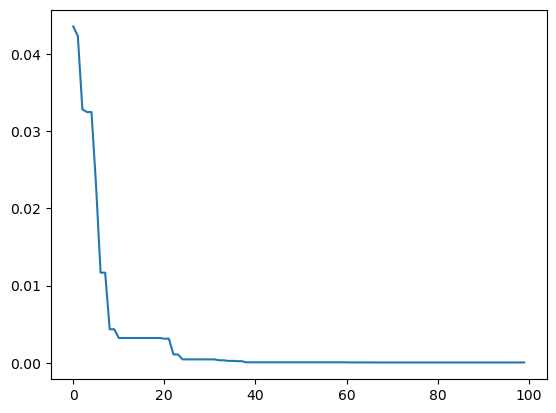

In [25]:
plt.plot(evaluations)

## 4.3. Using Genetic Algorithm for Network optimization

### 4.3.1. iris dataset

In [26]:
# fetch dataset 
iris = fetch_ucirepo(id=53)

In [27]:
# data (as pandas dataframes) 
iris_X = iris.data.features.values
iris_y = iris.data.targets.values

In [28]:
iris_dictionary = {value: key for key, value in enumerate(np.unique(iris_y))}
iris_y = np.vectorize(iris_dictionary.get)(iris_y)

In [29]:
iris_y_encoded = encode_one_hot(iris_y)

In [30]:
iris_train_idx = np.random.choice(range(len(iris_X)), int(0.7 * len(iris_X)))
iris_test_idx = np.setdiff1d(range(len(iris_X)), iris_train_idx)

iris_X_train = iris_X[iris_train_idx]
iris_y_train = iris_y_encoded[iris_train_idx]
iris_X_test = iris_X[iris_test_idx]
iris_y_test = iris_y_encoded[iris_test_idx]

In [31]:
iris_nn = Network([4, 10, 3], Activation.Type.SIGMOID, Activation.Type.SOFTMAX, Weights.Type.HE)

In [32]:
def cost_iris_nn(config):
    iris_nn.set_parameters(config)
    
    return Cost.CrossEntropy().get(iris_y_train, iris_nn.predict(iris_X_train))

In [33]:
iris_ga = GeneticAlgorithm(50, 50, 0.8, 0.8)

In [34]:
iris_start = time.time()
iris_solutions, iris_evaluations = iris_ga.optimize(cost_iris_nn, len(iris_nn.get_parameters()), 'gauss', iris_nn.tuples())
iris_end = time.time()

In [35]:
iris_evaluation_time, _, _, _ = d(iris_start, iris_end)
print(f'evaluated in {iris_evaluation_time}')

evaluated in 0h 0m 7s


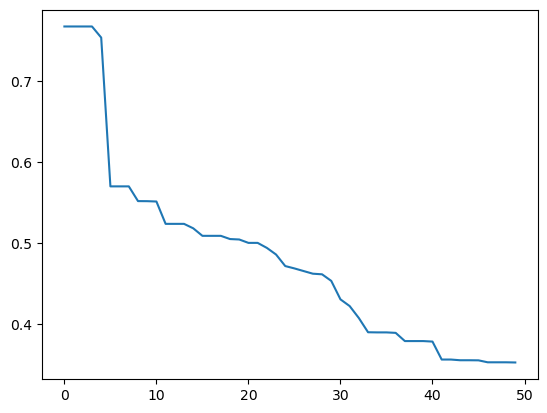

In [36]:
plt.plot(iris_evaluations)

In [37]:
print(f'last evaluation: {iris_evaluations[-1]}')

last evaluation: 0.3527728918864063


In [38]:
iris_nn.set_parameters(iris_solutions[-1])

In [39]:
print(f'{Metric.F_score().get(iris_y_test, encode_one_hot(iris_nn.classify(iris_X_test)))}')

[1.         0.84615385 0.81818182]


### 4.3.2. multimodal-large

In [40]:
mml_train = pd.read_csv('../data/multimodal-large-training.csv')
mml_test = pd.read_csv('../data/multimodal-large-test.csv')

In [41]:
mml_X_train = mml_train[['x']].values
mml_y_train = mml_train[['y']].values
mml_X_test = mml_test[['x']].values
mml_y_test = mml_test[['y']].values

In [42]:
mml_nn = Network([1, 6, 6, 1], Activation.Type.TANH, Activation.Type.LINEAR, Weights.Type.HE)

In [43]:
def cost_mml_nn(config):
    mml_nn.set_parameters(config)
    
    return Cost.MSE().get(mml_y_train, mml_nn.predict(mml_X_train))

In [44]:
mml_ga = GeneticAlgorithm(50, 50, 0.8, 0.8)

In [45]:
mml_start = time.time()
mml_solutions, mml_evaluations = mml_ga.optimize(cost_mml_nn, len(mml_nn.get_parameters()), 'gauss', mml_nn.tuples())
mml_end = time.time()

In [46]:
mml_evaluation_time, _, _, _ = d(mml_start, mml_end)
print(f'evaluated in {mml_evaluation_time}')

evaluated in 0h 2m 31s


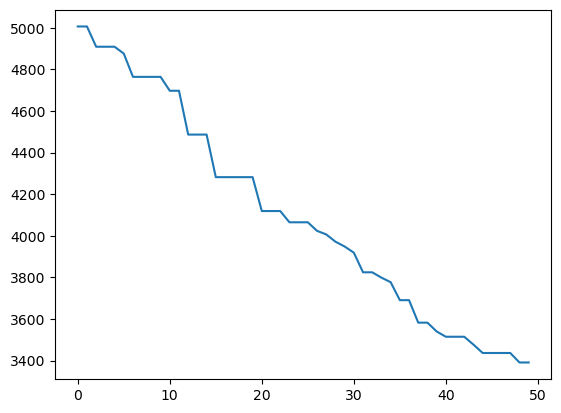

In [47]:
plt.plot(mml_evaluations)

In [48]:
print(f'last evaluation: {mml_evaluations[-1]}')

last evaluation: 3391.0661701885297


In [49]:
print(f'last solution: {mml_solutions[-1]}')

last solution: [ 1.75893709 -1.50193044 -2.50336357  1.50020766  0.31585147  1.95997161
 -6.76891505 -4.37267095 -5.05284819 -4.15773993 -3.56852524 -5.37610328
 -2.80326819 -4.07934856 -4.02279661 -3.63389987 -2.86962844 -4.18304135
 -3.07269603 -2.4183056  -2.39329053 -0.65188378 -2.29755016 -1.14054073
 -1.54918924 -3.28369706 -0.74686214 -3.4149422  -3.03237973 -3.47311533
 -2.0805753  -2.51895605 -2.47535811 -2.49126046 -2.24226514 -0.75510915
 -1.81954804 -2.16801784 -1.29207165 -2.40948507 -0.38210465 -1.69536799
 -5.45485477 -3.84525546 -3.75489654 -4.30389603 -4.02076468 -5.18420702
 -1.05015511  0.17791041 -2.22516505 -1.36503603  1.61254171 -2.31863789
 -3.57898453 -3.21508571 -0.67510133 -2.63948871 -3.79840943 -2.49813174
  2.87329961]


In [50]:
mml_nn.set_parameters(mml_solutions[-1])

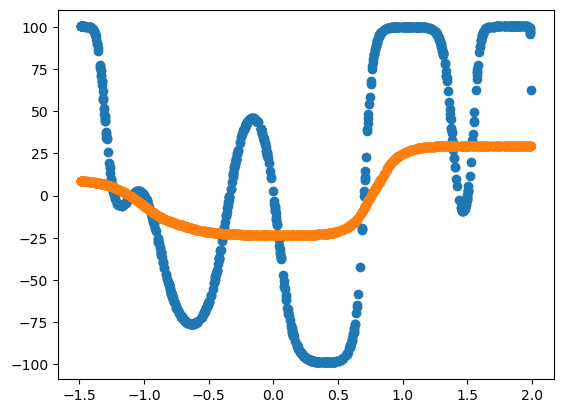

In [51]:
plt.scatter(mml_X_test, mml_y_test)
plt.scatter(mml_X_test, mml_nn.predict(mml_X_test))

In [52]:
print(f'{Metric.MSE().get(mml_y_test, mml_nn.predict(mml_X_test))}')

3411.3695596187767


### 4.3.3. auto-mpg dataset

In [53]:
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9)

In [54]:
# data (as pandas dataframes) 
auto_mpg_X = auto_mpg.data.features.values
auto_mpg_y = auto_mpg.data.targets.values

In [55]:
invalid_indexes = np.unique(np.append(np.argwhere(np.isnan(auto_mpg_X))[:,0], np.argwhere(np.isnan(auto_mpg_y))[:,0]))

In [56]:
auto_mpg_X = auto_mpg_X[[i for i, row in enumerate(auto_mpg_X) if i not in invalid_indexes]]
auto_mpg_y = auto_mpg_y[[i for i, row in enumerate(auto_mpg_y) if i not in invalid_indexes]]

In [57]:
auto_mpg_train_idx = np.random.choice(range(len(auto_mpg_X)), int(0.7 * len(auto_mpg_X)), replace=False)
auto_mpg_test_idx = np.setdiff1d(range(len(auto_mpg_X)), auto_mpg_train_idx)

auto_mpg_X_train = auto_mpg_X[auto_mpg_train_idx]
auto_mpg_y_train = auto_mpg_y[auto_mpg_train_idx]
auto_mpg_X_test = auto_mpg_X[auto_mpg_test_idx]
auto_mpg_y_test = auto_mpg_y[auto_mpg_test_idx]

In [58]:
auto_mpg_nn = Network([7, 10, 1], Activation.Type.TANH, Activation.Type.LINEAR, Weights.Type.HE)

In [59]:
def cost_auto_mpg_nn(config):
    auto_mpg_nn.set_parameters(config)
    
    return Cost.MSE().get(auto_mpg_y_train, auto_mpg_nn.predict(auto_mpg_X_train))

In [60]:
auto_mpg_ga = GeneticAlgorithm(50, 50, 0.8, 0.8)

In [61]:
auto_mpg_start = time.time()
auto_mpg_solutions, auto_mpg_evaluations = auto_mpg_ga.optimize(cost_auto_mpg_nn, len(auto_mpg_nn.get_parameters()), 'gauss', auto_mpg_nn.tuples())
auto_mpg_end = time.time()

In [62]:
auto_mpg_evaluation_time, _, _, _ = d(auto_mpg_start, auto_mpg_end)
print(f'evaluated in {auto_mpg_evaluation_time}')

evaluated in 0h 0m 7s


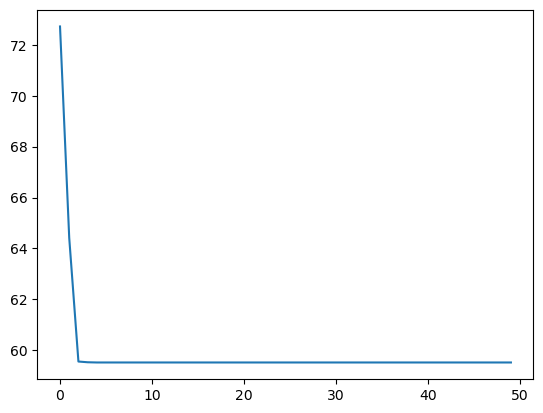

In [63]:
plt.plot(auto_mpg_evaluations)

In [64]:
print(f'last evaluation: {auto_mpg_evaluations[-1]}')

last evaluation: 59.51276348489981


In [65]:
print(f'last solution: {auto_mpg_solutions[-1]}')

last solution: [ 2.51377296  2.6208025   0.88715542  3.10999029  1.55541414  0.31122358
 -0.11787852  2.32832236  1.86730823  2.9223491   1.03392517  1.9104571
  2.34691932  2.18688265  1.5106048   2.0098776   1.43469633  1.47365342
  1.31390951  0.72340564  0.56682712  1.60587856  3.31203294  0.5484391
  1.71189202  0.77601418  2.71571923  3.04614753  3.0352764   0.9987269
  3.85258821  1.69150261  3.84251279  2.70559962  3.69179466  2.9458494
  5.17014898  2.58722526  3.3862643   2.94254052  5.09401711  3.52242994
  2.46692436  2.74121274  1.51054432  1.90115777  3.14096501  1.95958959
  1.32718686  0.98533158  3.80873397  1.49409584  2.4885459   4.3723892
  2.73698711  2.73861454  2.83372088  3.22006474  3.08657941  3.25451127
  4.0081604   2.54600656  1.65519882  2.63204398  1.51257695  3.08604054
  3.92603474  1.7006678   1.43874268  1.89984477  3.3735165   0.64535389
  0.61301573  2.44432452  2.53090373  3.06860209  1.42789222  2.09461525
  2.31312338  2.23928716  4.65170231  2.8

In [66]:
auto_mpg_nn.set_parameters(auto_mpg_solutions[-1])

In [67]:
print(f'{Metric.MSE().get(auto_mpg_y_test, auto_mpg_nn.predict(auto_mpg_X_test))}')

63.73829310195137
